In [1]:
from pathlib import Path
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
import mrcnn.model as DataGenerator
from mrcnn import visualize
from mrcnn.model import log
import pandas as pd
import os
import random
import cv2
import numpy as np
import ast
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0" #please put your GPU

In [3]:
# DATA_DIR = Path('../working/')
# ROOT_DIR = "../../working"
# resized_folder = "working/resized_train/"
NUM_CATS = 14
IMAGE_SIZE = 512
selected_classes = list(i for i in range(14)) 
category_list = ['Aortic enlargement','Atelectasis','Calcification',
                'Cardiomegaly','Consolidation','ILD','Infiltration','Lung Opacity',
                'Nodule/Mass','Other lesion','Pleural effusion','Pleural thickening',
                'Pneumothorax','Pulmonary fibrosis']

In [4]:
## Load data
samples_df = pd.read_csv('train_512.csv')

In [5]:
class DiagnosticConfig(Config):
    NAME = "Diagnostic"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 #That is the maximum with the memory available on kernels
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'

    POST_NMS_ROIS_TRAINING = 250
    POST_NMS_ROIS_INFERENCE = 150
    MAX_GROUNDTRUTH_INSTANCES = 5
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    BACKBONESHAPE = (8, 16, 24, 32, 48)
    RPN_ANCHOR_SCALES = (8,16,24,32,48)
    ROI_POSITIVE_RATIO = 0.33
    DETECTION_MAX_INSTANCES = 300
    DETECTION_MIN_CONFIDENCE = 0.7    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = int(len(samples_df)*0.9/IMAGES_PER_GPU)
    VALIDATION_STEPS = len(samples_df)-int(len(samples_df)*0.9/IMAGES_PER_GPU)
    
config = DiagnosticConfig()
config.display()



Configurations:
BACKBONE                       resnet50
BACKBONESHAPE                  (8, 16, 24, 32, 48)
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        300
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                27
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL

In [6]:
## Model load weight 
class InferenceConfig(DiagnosticConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    DETECTION_MIN_CONFIDENCE = 0.8
    DETECTION_NMS_THRESHOLD = 0.5

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir="")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
model.load_weights('logs/mask_rcnn_shapes_rev.01.h5', by_name=True)

In [8]:
resized_test_folder = "train/"
#os.mkdir(resized_test_folder)

In [9]:
from skimage.measure import find_contours
from matplotlib.patches import Polygon


# Fix overlapping masks
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

def decode_rle(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height*width, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape((height, width)).T

def annotations_to_mask(annotations, height, width):
    if isinstance(annotations, list):
        # The annotation consists in a list of RLE codes
        mask = np.zeros((height, width, len(annotations)))
        for i, rle_code in enumerate(annotations):
            mask[:, :, i] = decode_rle(rle_code, height, width)
    else:
        error_message = "{} is expected to be a list or str but received {}".format(annotation, type(annotation))
        raise TypeError(error_message)
    return mask

def find_anomalies(dicom_image, display=False):

    image_dimensions = dicom_image.shape
    image_size = 512
    resized_img = cv2.resize(dicom_image, (image_size,image_size), interpolation = cv2.INTER_AREA)
    saved_filename = resized_test_folder+"temp_image.png"
    cv2.imwrite(saved_filename, resized_img) 
    img = cv2.imread(saved_filename)

    result = model.detect([img])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = image_dimensions[0]/IMAGE_SIZE
        x_scale = image_dimensions[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    if display:
        visualize.display_instances(img, rois, masks, r['class_ids'], 
                                    ['bg']+category_list, r['scores'],
                                    title="prediction", figsize=(12, 12))
    return rois, r['class_ids'], r['scores']

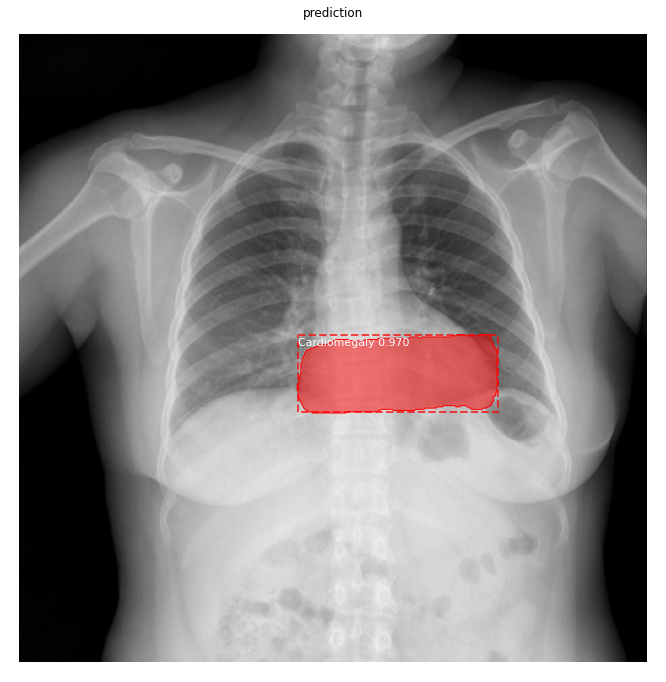

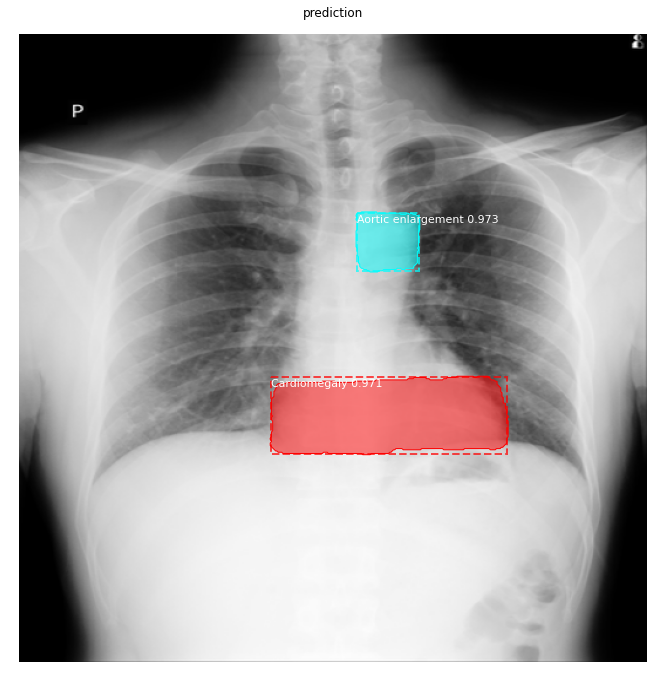

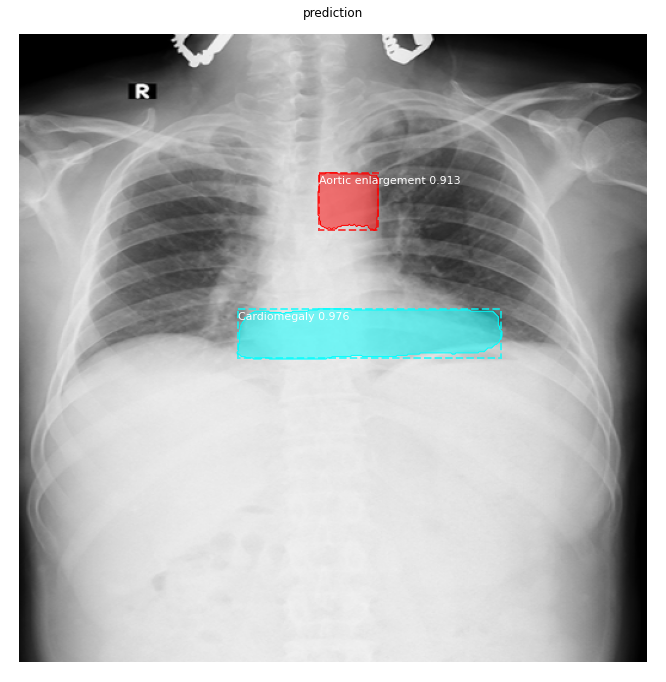

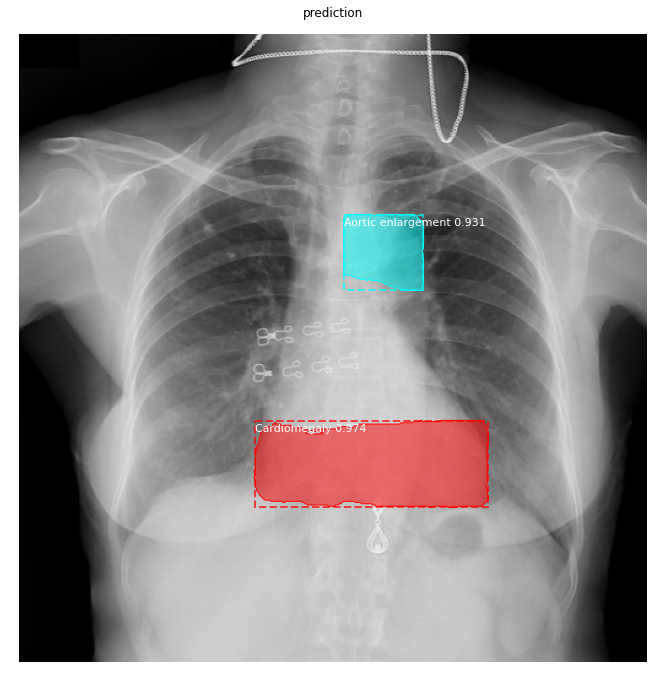

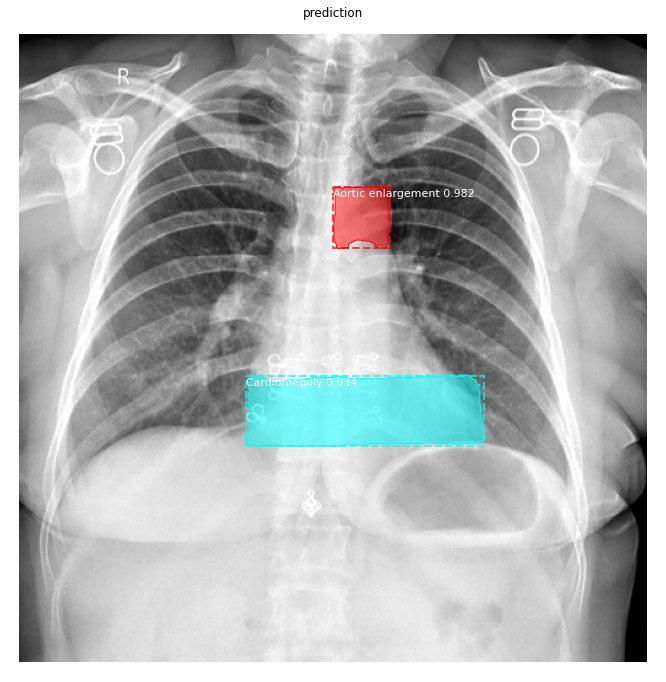

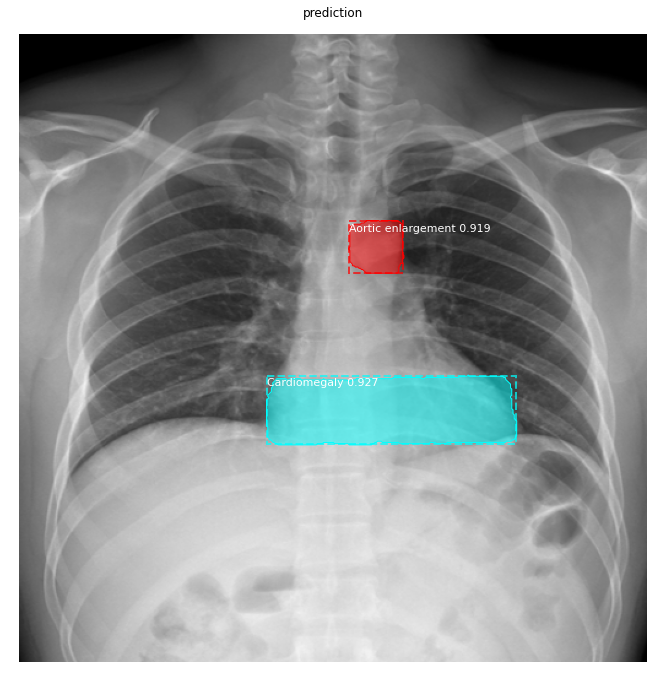

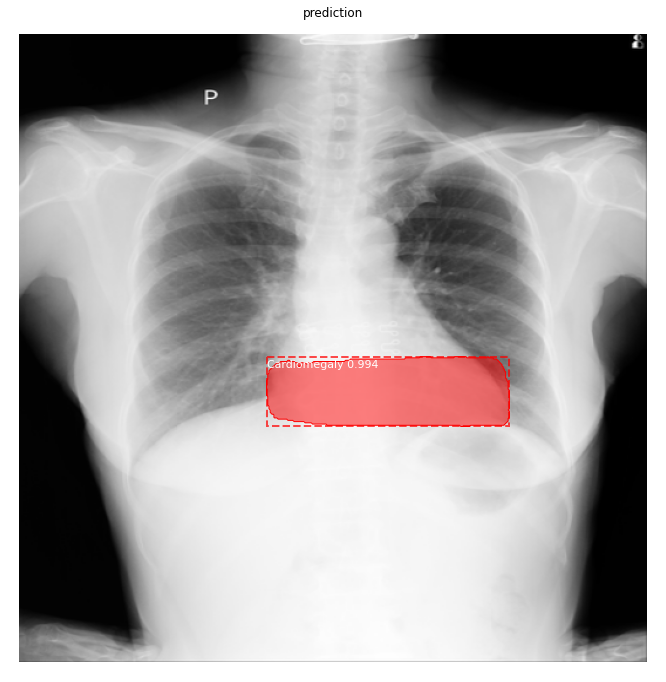

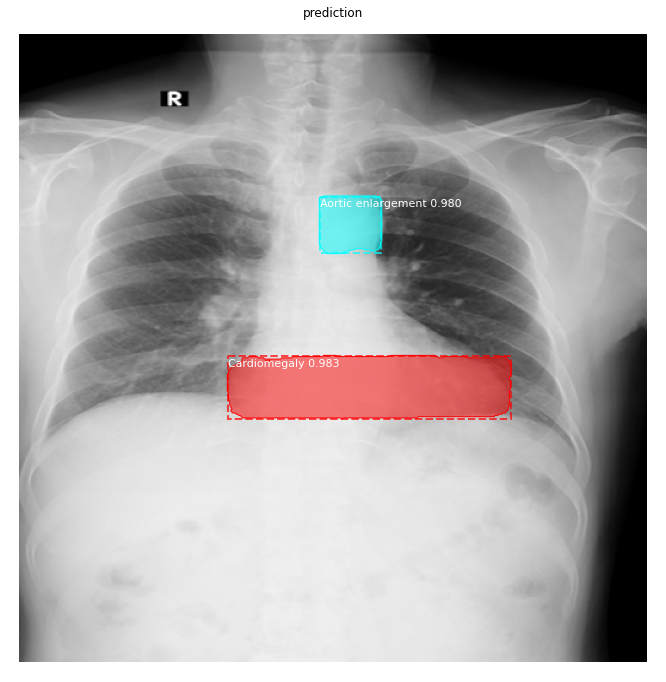

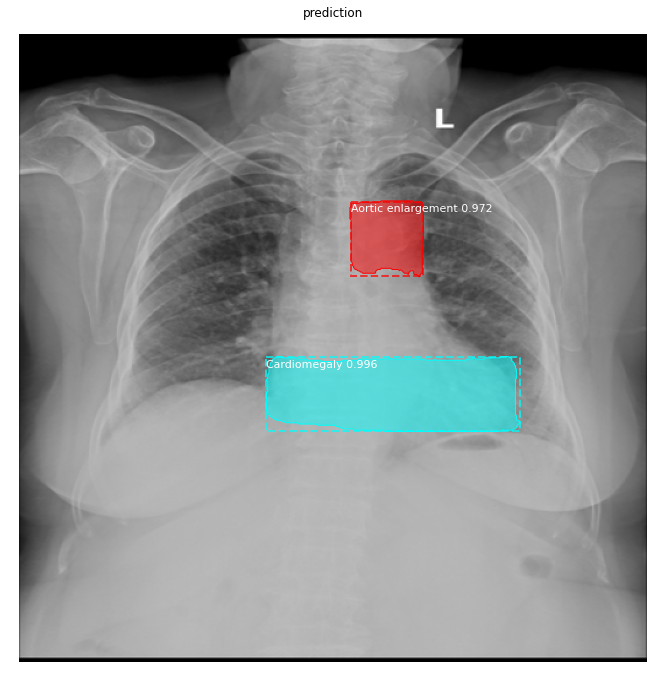

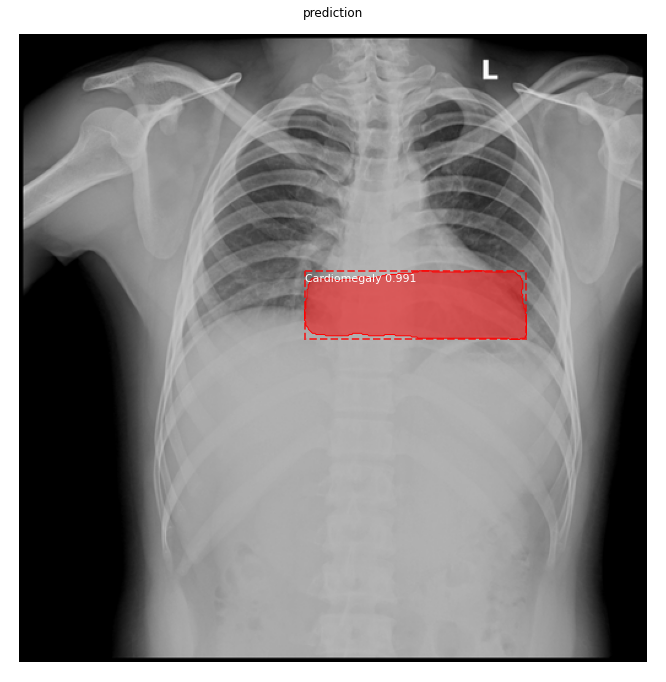

In [10]:
test_folder = "train/"
test_file_list = os.listdir(test_folder)[50:60]

for test_file in test_file_list:
    dicom_image = cv2.imread(test_folder+test_file)
    find_anomalies(dicom_image, display=True)

In [11]:
samples_df[samples_df['CategoryId']=='[14]']

,Unnamed: 0,image_id,CategoryId,EncodedPixels,Rad_id,Height,Width


In [13]:
def load_image(name, path):
    img_path = path + name + '.png'
    img = cv2.imread(img_path)
    img = cv2.resize(img, (512, 512), interpolation = cv2.INTER_AREA)
    return img

def plot_image(img):
    plt.imshow(img)
    plt.title(img.shape)
    
# Plot a grid of examples
def plot_grid(img_names, img_root, rows=5, cols=5):
    fig = plt.figure(figsize=(25,25))
    
    for i,name in enumerate(img_names):
        fig.add_subplot(rows,cols,i+1)
        img = load_image(name, img_root)
        plot_image(img)
        
    plt.show()
    
    
def resize(org_size, new_size):
    return org_size/new_size

In [15]:
def class_to_color(class_id):
    colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255),(255,100,100),
              (100,255,100),(100,100,255),(255,100,0),(255,0,100),(100,0,255),(100,100,255),(100,255,0),
              (100,255,100)]
    return colors[class_id]

# draw a single bounding box onto a numpy array image
def draw_bounding_box(img, annotation):
    if annotation.isnull().values.any():
        return
    
    x_min, y_min = int(annotation['x_min_scaled']), int(annotation['y_min_scaled'])
    x_max, y_max = int(annotation['x_max_scaled']), int(annotation['y_max_scaled'])
    
    class_id = int(annotation['class_id'])
    color = class_to_color(class_id)
    
    cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)

# draw all annotation bounding boxes on an image
def annotate_image(img, name, all_annotations):
    annotations = all_annotations[all_annotations['image_id'] == name]
    for index, row in annotations.iterrows():
        draw_bounding_box(img, row)

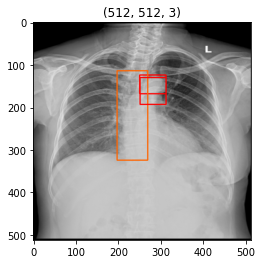

In [17]:
# Plot a single sample with all its bounding boxes
## Load data
import matplotlib.pyplot as plt

samples_df = pd.read_csv('train_scaled_rev.01.csv')

IMG_ROOT = 'train/'
name = os.listdir(test_folder)[300][:-4]
img = load_image(name, IMG_ROOT)
annotate_image(img, name, samples_df)
plot_image(img)

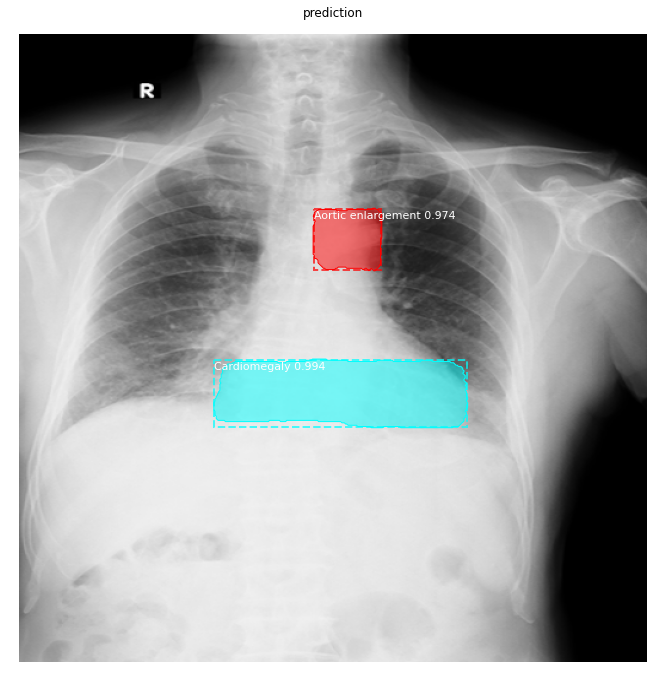

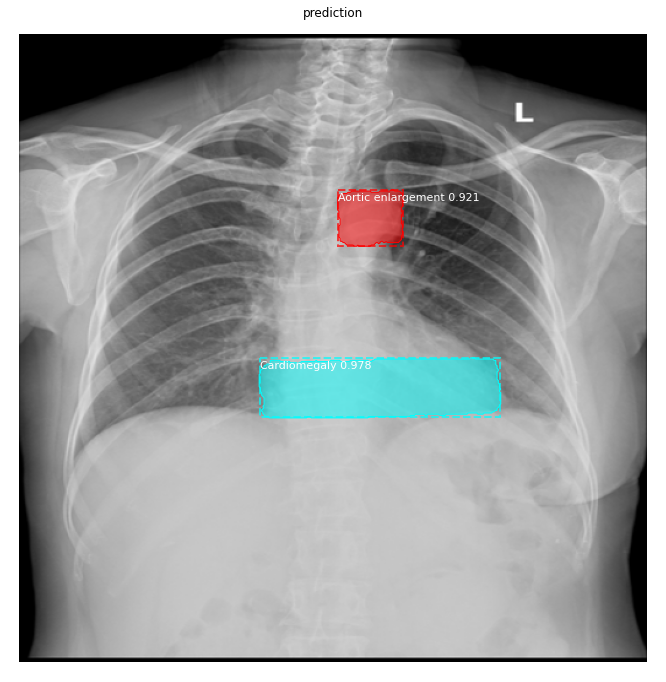

In [20]:
test_folder = "train/"
test_file_list = os.listdir(test_folder)[299:301]

for test_file in test_file_list:
    dicom_image = cv2.imread(test_folder+test_file)
    find_anomalies(dicom_image, display=True)